# Expectile VaR (EVaR) for **returns** with Classiq + IQAE


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

from classiq import *
from classiq.applications.iqae.iqae import IQAE


## 1) Discretize a return distribution



In [2]:
num_qubits = 9
N = 2**num_qubits

# Return distribution
mu, sigma = 0.05, 0.20

# Discretization grid
L = 4.0
grid = np.linspace(-L, L, N)
pdf = stats.norm.pdf(grid, loc=mu, scale=sigma)
probs = (pdf / pdf.sum()).astype(float)

assert np.isclose(probs.sum(), 1.0)
print('N=', N, 'sum(probs)=', probs.sum())


N= 512 sum(probs)= 0.9999999999999998


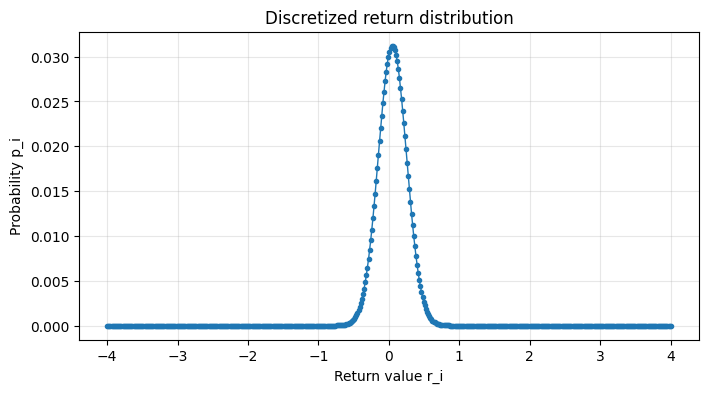

In [3]:
plt.figure(figsize=(8,4))
plt.plot(grid, probs, marker='.', linewidth=1)
plt.xlabel('Return value r_i')
plt.ylabel('Probability p_i')
plt.title('Discretized return distribution')
plt.grid(True, alpha=0.3)
plt.show()


## 2) EVaR / expectile definition (returns)

In [4]:
def beta_from_alpha(alpha: float) -> float:
    if not (0.5 < alpha < 1.0):
        raise ValueError('alpha must be in (0.5, 1) for expectiles in this form')
    return (2*alpha - 1) / (1 - alpha)

def phi_e(r: np.ndarray, e: float, beta: float) -> np.ndarray:
    # phi_e(r) = max((1+beta)r - beta e, r) = r + beta * max(r-e,0)
    return r + beta * np.maximum(r - e, 0.0)

def h_of_e_exact(grid: np.ndarray, probs: np.ndarray, e: float, beta: float) -> float:
    return float(np.dot(probs, phi_e(grid, e, beta)))

def expectile_bisection_exact(grid: np.ndarray, probs: np.ndarray, alpha: float, tol=1e-6, max_iter=200):
    beta = beta_from_alpha(alpha)
    a, b = float(grid.min()), float(grid.max())
    # g(e) = h(e) - e; want g(e)=0
    def g(e):
        return h_of_e_exact(grid, probs, e, beta) - e
    ga, gb = g(a), g(b)
    # In typical cases with alpha>0.5, g(a) >= 0 and g(b) <= 0.
    # If not, we still run bisection but you may need a wider bracket.
    for _ in range(max_iter):
        m = 0.5*(a+b)
        gm = g(m)
        if abs(gm) < tol:
            return m
        # decide side
        if np.sign(gm) == np.sign(ga):
            a, ga = m, gm
        else:
            b, gb = m, gm
    return 0.5*(a+b)


### Quick classical check (exact on the discretized grid)



In [5]:
alpha = 0.90
beta = beta_from_alpha(alpha)
e_exact = expectile_bisection_exact(grid, probs, alpha, tol=1e-10)
print(f'alpha={alpha}, beta={beta:.6f}, expectile e_exact={e_exact:.6f}')


alpha=0.9, beta=8.000000, expectile e_exact=0.222342


## 3) Quantum piece: IQAE estimates an expectation


In [6]:
def phi_bounds(grid: np.ndarray, alpha: float):
    """Bounds for phi_e(r) over r in [minR,maxR] and e in [minR,maxR].
    phi_min is always minR because phi_e(r) >= r.
    phi_max achieved at r=maxR, e=minR: maxR + beta*(maxR-minR).
    """
    beta = beta_from_alpha(alpha)
    rmin, rmax = float(grid.min()), float(grid.max())
    phi_min = rmin
    phi_max = rmax + beta*(rmax - rmin)
    return phi_min, phi_max

def build_split_probs_for_e(grid: np.ndarray, probs: np.ndarray, e: float, alpha: float):
    beta = beta_from_alpha(alpha)
    phi = phi_e(grid, e, beta)
    phi_min, phi_max = phi_bounds(grid, alpha)
    denom = (phi_max - phi_min)
    f = (phi - phi_min) / denom
    # numerical safety
    f = np.clip(f, 0.0, 1.0)
    # concatenate: [block0, block1]
    p0 = probs * (1.0 - f)
    p1 = probs * f
    split = np.concatenate([p0, p1]).astype(float)
    split /= split.sum()
    return split, (phi_min, phi_max)

def expect_h_via_iqae(e: float, alpha: float, eps=0.02, alpha_fail=0.01, show_qprog=False):
    """Estimate h(e)=E[phi_e(R)] using IQAE, via the split-probability trick."""
    global ACTIVE_PROBS
    split_probs, (phi_min, phi_max) = build_split_probs_for_e(grid, probs, e, alpha)
    ACTIVE_PROBS = split_probs.tolist()
    
    # asset register is now (num_qubits+1) because we doubled the number of basis states
    asset_bits = num_qubits + 1
    threshold = 2**num_qubits  # N

    @qfunc
    def load_distribution(asset: QNum):
        inplace_prepare_state(ACTIVE_PROBS, bound=0, target=asset)

    @qperm
    def payoff(asset: Const[QNum], ind: QBit):
        ind ^= asset >= threshold

    @qfunc(synthesize_separately=True)
    def state_preparation(asset: QNum, ind: QBit):
        load_distribution(asset)
        payoff(asset, ind)

    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=asset_bits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=asset_bits),
    )
    if show_qprog:
        show(iqae.get_qprog())
    res = iqae.run(epsilon=eps, alpha=alpha_fail)
    est = float(res.estimation)  # ≈ E[f]
    h_est = phi_min + est*(phi_max - phi_min)
    return h_est, est, res


## 4) EVaR via bisection, with IQAE inside


In [7]:
def expectile_bisection_iqae(alpha: float, eps=0.02, alpha_fail=0.01, tol=1e-3, max_iter=60, show_first_qprog=False):
    beta = beta_from_alpha(alpha)
    a, b = float(grid.min()), float(grid.max())
    
    def g(e, show=False):
        h_est, est_f, res = expect_h_via_iqae(e, alpha, eps=eps, alpha_fail=alpha_fail, show_qprog=show)
        return (h_est - e), h_est, est_f, res

    ga, ha, _, _ = g(a, show=show_first_qprog)
    gb, hb, _, _ = g(b)

    history = []
    for it in range(max_iter):
        m = 0.5*(a+b)
        gm, hm, est_f, res = g(m)
        history.append((it, a, b, m, gm, hm, est_f))
        if abs(gm) < tol:
            return m, pd.DataFrame(history, columns=['iter','a','b','m','g(m)','h(m)','E[f]'])
        # bisection update
        if np.sign(gm) == np.sign(ga):
            a, ga = m, gm
        else:
            b, gb = m, gm
    return 0.5*(a+b), pd.DataFrame(history, columns=['iter','a','b','m','g(m)','h(m)','E[f]'])

e_iqae, hist = expectile_bisection_iqae(alpha=alpha, eps=0.03, alpha_fail=0.01, tol=3e-3, show_first_qprog=False)
print(f'EVaR/expectile (IQAE) e_iqae={e_iqae:.6f}')
print(f'EVaR/expectile (exact) e_exact={e_exact:.6f}')
print('abs error:', abs(e_iqae - e_exact))

hist.tail(10)


EVaR/expectile (IQAE) e_iqae=0.250854
EVaR/expectile (exact) e_exact=0.222342
abs error: 0.02851263026241213


,iter,a,b,m,g(m),h(m),E[f]
6,6,0.250000,0.375000,0.312500,-0.325659,-0.013159,0.055373
7,7,0.250000,0.312500,0.281250,-0.255245,0.026005,0.055917
8,8,0.250000,0.281250,0.265625,-0.086086,0.179539,0.058049
9,9,0.250000,0.265625,0.257812,-0.045087,0.212726,0.058510
10,10,0.250000,0.257812,0.253906,-0.151406,0.102500,0.056979
11,11,0.250000,0.253906,0.251953,-0.007638,0.244315,0.058949
12,12,0.250000,0.251953,0.250977,-0.087992,0.162985,0.057819
13,13,0.250000,0.250977,0.250488,0.118480,0.368968,0.060680
14,14,0.250488,0.250977,0.250732,0.034251,0.284983,0.059514
15,15,0.250732,0.250977,0.250854,0.000718,0.251573,0.059050


### Visualize the bisection progress
`g(m)=h(m)-m` should converge toward 0.


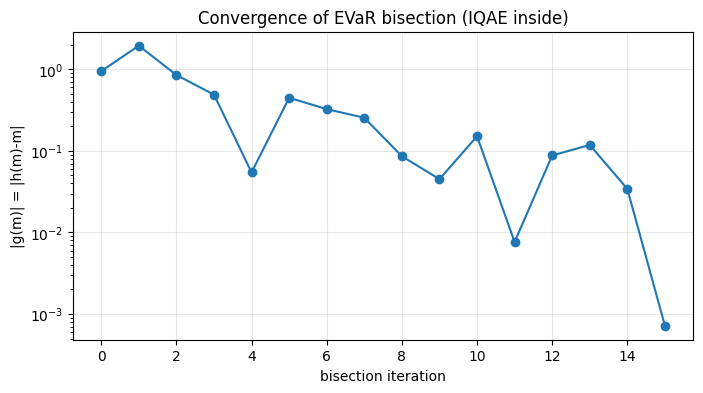

In [8]:
plt.figure(figsize=(8,4))
plt.plot(hist['iter'], np.abs(hist['g(m)']), marker='o')
plt.yscale('log')
plt.xlabel('bisection iteration')
plt.ylabel('|g(m)| = |h(m)-m|')
plt.title('Convergence of EVaR bisection (IQAE inside)')
plt.grid(True, alpha=0.3)
plt.show()


## 5) Benchmarking



In [9]:
def expectile_from_samples(samples: np.ndarray, alpha: float, tol=1e-6, max_iter=200):
    beta = beta_from_alpha(alpha)
    a, b = float(np.min(samples)), float(np.max(samples))
    def h(e):
        return float(np.mean(phi_e(samples, e, beta)))
    def g(e):
        return h(e) - e
    ga, gb = g(a), g(b)
    for _ in range(max_iter):
        m = 0.5*(a+b)
        gm = g(m)
        if abs(gm) < tol:
            return m
        if np.sign(gm) == np.sign(ga):
            a, ga = m, gm
        else:
            b, gb = m, gm
    return 0.5*(a+b)

# Monte Carlo reference
rng = np.random.default_rng(7)
mc_samples = rng.normal(loc=mu, scale=sigma, size=400_000)
e_mc = expectile_from_samples(mc_samples, alpha, tol=1e-5)
print(f'e_exact (grid) = {e_exact:.6f}')
print(f'e_mc (400k)   = {e_mc:.6f}')
print(f'|e_mc - e_exact| = {abs(e_mc-e_exact):.6f}')


e_exact (grid) = 0.222342
e_mc (400k)   = 0.222352
|e_mc - e_exact| = 0.000011


### IQAE accuracy vs epsilon (work/accuracy tradeoff)
Smaller `epsilon` means tighter accuracy target for IQAE, typically requiring more quantum work.


In [10]:
eps_list = [0.20, 0.10, 0.05, 0.03, 0.02]
alpha_fail = 0.01

bench = []
for eps in eps_list:
    e_hat, _hist = expectile_bisection_iqae(alpha=alpha, eps=eps, alpha_fail=alpha_fail, tol=max(2*eps, 3e-3), max_iter=60)
    bench.append({
        'epsilon': eps,
        'e_iqae': float(e_hat),
        'abs_err_vs_exact': float(abs(e_hat - e_exact)),
        'abs_err_vs_mc': float(abs(e_hat - e_mc)),
        'bisection_iters': int(len(_hist)),
    })

df_bench = pd.DataFrame(bench).sort_values('epsilon', ascending=False)
df_bench


,epsilon,e_iqae,abs_err_vs_exact,abs_err_vs_mc,bisection_iters
0,0.20,0.50000,0.277658,0.277648,4
1,0.10,0.28125,0.058908,0.058898,8
2,0.05,0.25000,0.027658,0.027648,5
3,0.03,0.25000,0.027658,0.027648,5
4,0.02,0.18750,0.034842,0.034852,7


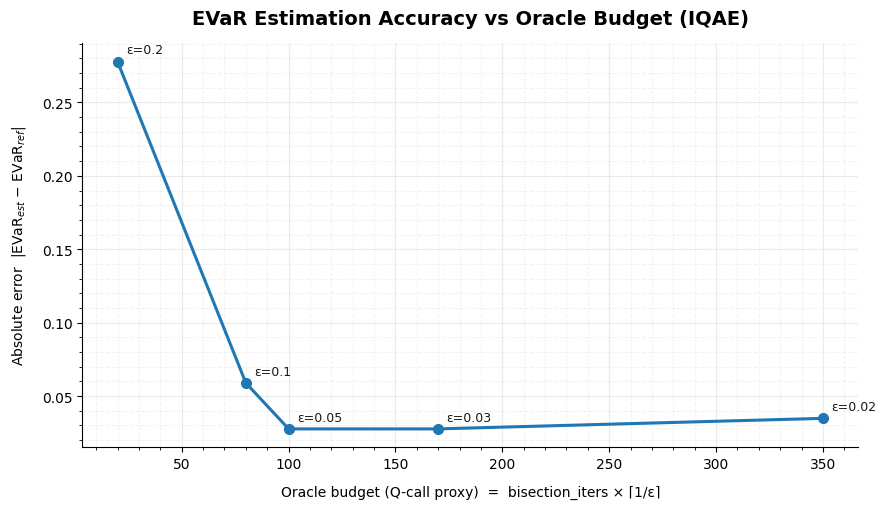

,epsilon,abs_err_vs_exact,bisection_iters,Qcalls
0,0.20,0.277658,4,20
1,0.10,0.058908,8,80
2,0.05,0.027658,5,100
3,0.03,0.027658,5,170
4,0.02,0.034842,7,350


In [ ]:

# -----------------------------
# Input: sweep summary
# -----------------------------
data = [
    # epsilon, abs_err_vs_exact, bisection_iters
    (0.20, 0.277658, 4),
    (0.10, 0.058908, 8),
    (0.05, 0.027658, 5),
    (0.03, 0.027658, 5),
    (0.02, 0.034842, 7),
]
df = pd.DataFrame(data, columns=["epsilon", "abs_err_vs_exact", "bisection_iters"])

# -----------------------------
# Simple oracle-budget proxy
# -----------------------------
df["Qcalls"] = df["bisection_iters"] * np.ceil(1.0 / df["epsilon"]).astype(int)
df = df.sort_values("Qcalls").reset_index(drop=True)

# -----------------------------
# Plot: professional polish
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 5.2))

ax.plot(
    df["Qcalls"],
    df["abs_err_vs_exact"],
    marker="o",
    linewidth=2.2,
    markersize=7,
)

ax.set_title("EVaR Estimation Accuracy vs Oracle Budget (IQAE)", pad=14, fontsize=14, fontweight="bold")
ax.set_xlabel("Oracle budget (Q-call proxy)  =  bisection_iters × ⌈1/ε⌉", labelpad=10)
ax.set_ylabel("Absolute error  |EVaR$_{est}$ − EVaR$_{ref}$|", labelpad=10)

ax.grid(True, which="major", linestyle="-", alpha=0.25)
ax.grid(True, which="minor", linestyle="--", alpha=0.15)
ax.minorticks_on()

# Make the chart feel “report-ready”
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Annotate each point with epsilon (small, clean)
for q, err, eps in zip(df["Qcalls"], df["abs_err_vs_exact"], df["epsilon"]):
    ax.annotate(f"ε={eps:g}", (q, err), textcoords="offset points", xytext=(6, 6), fontsize=9, alpha=0.9)

# Optional: tighten layout and show
fig.tight_layout()
plt.show()

df
